## 0. Load Project

### 0.1. Clone Project Repository

In [2]:
!git clone https://github.com/AHS-uni/speech-processing.git && cd speech-processing

Cloning into 'speech-processing'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 41 (delta 3), reused 41 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (41/41), 8.50 MiB | 11.20 MiB/s, done.
Resolving deltas: 100% (3/3), done.


### 0.2. Download and Extract Dataset Files

In [7]:
!mkdir -p data/LJSpeech \
&& wget -q https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2 \
       -O data/LJSpeech/LJSpeech-1.1.tar.bz2 \
  && tar -xjf data/LJSpeech/LJSpeech-1.1.tar.bz2 \
           -C data/LJSpeech \
  && echo "Downloaded and extracted to /content/data/LJSpeech"

Downloaded and extracted to /content/data/LJSpeech


## 1. Environment and Config

In [10]:
import os
import random

from src.config import load_config

### 1.1. Package Installs

Install dependencies if needed.

In [9]:
!pip install --quiet torchaudio librosa soundfile sentencepiece jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 108.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 58.1 MB/s eta 0:00:00


### 1.2. Load Config

In [41]:
cfg = load_config("config.yaml")
DATASET_DIR   = cfg["dataset_dir"]
SPLIT_DIR     = cfg["splits_dir"]
PREP_DIR      = cfg["preprocessed_dir"]
STATS_DIR     = cfg["stats_dir"]
TOKENIZER_DIR = cfg["tokenizer_dir"]

# Ensure directories
for d in (DATASET_DIR, SPLIT_DIR, PREP_DIR, STATS_DIR, TOKENIZER_DIR):
    os.makedirs(d, exist_ok=True)

### 1.3. Random State

In [16]:
random.seed(cfg.get("random_seed", 42))

## 2. Load LJSpeech


### About the LJSpeech Dataset

- **13 100** English utterances (~24 hours) read by a single female speaker.  
- Transcripts drawn from 19th-century texts (public domain).  
- Already **“normalized_transcript”** may contain uppercase letters and unexpected symbols—we’ll audit and clean.  
- We use **torchaudio.datasets.LJSPEECH** for convenient streaming from disk.  

In [17]:
from torchaudio.datasets import LJSPEECH
from IPython.display import Audio

In [18]:
# Load dataset
dataset = LJSPEECH(root=DATASET_DIR, download=False)
total   = len(dataset)
print(f"Loaded LJSpeech with {total} samples")

Loaded LJSpeech with 13100 samples


In [20]:
# Inspect a sample
waveform, sr, transcript, norm_transcript = dataset[2]
print("Waveform shape:", waveform.shape)
print("Sample rate:   ", sr)
print("Raw text:      ", transcript)
print("Normalized:    ", norm_transcript)
Audio(waveform.numpy(), rate=sr)

Waveform shape: torch.Size([1, 213149])
Sample rate:    22050
Raw text:       For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process
Normalized:     For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process


## 3. Audio → log-Mel Spectrogram

The log-Mel spectrogram approximates the cochlear frequency response:

$$
S_{\mathrm{dB}}(t, f) = 10 \log_{10}\bigl(\mathrm{MelSpectrogram}(x(t))\bigr)
$$

- **STFT → power spectrum**  
- Apply **Mel filterbank**: warps linear frequencies \(f\) to Mel scale \(m(f)\).  
- Convert to **decibels** for dynamic range compression.  

These 2D representations $[n\_mels \times T]$ are standard inputs to modern ASR models.  

In [22]:
import torch
from src.audio_processing import LogMelSpectrogram

In [27]:
logmel = LogMelSpectrogram(
    sample_rate=sr,
    n_fft=cfg["n_fft"],
    hop_length=cfg["hop_length"],
    n_mels=cfg["n_mels"],
)

### 3.1. Example on One Waveform

In [28]:
spec = logmel(waveform)
print("Log-Mel shape:", spec.shape)

Log-Mel shape: torch.Size([80, 833])


Each spectrogram frame corresponds to a window of length `n_fft` sliding over the waveform in steps of `hop_length`.  If your waveform has $N$ samples, then the number of frames $T$ is:

$$
T = \biggl\lceil \frac{N}{\text{hop_length}} \biggr\rceil
$$

In our example:
- The waveform length $N$ is the number of samples in the tensor `waveform.shape[1]`.  
- With `hop_length = 256`, we compute:

$$
T = \left\lceil \frac{N}{256} \right\rceil.
$$

We can easily to fetch $N$ and compute $T$ for this example as a demonstration.

In [61]:
N = waveform.shape[1]
hop = cfg["hop_length"]
T = int(np.ceil(N / hop))
print(f"Waveform length N = {N} samples")
print(f"With hop_length = {hop}, number of frames T = ceil(N/hop) = {T}")

Waveform length N = 213149 samples
With hop_length = 256, number of frames T = ceil(N/hop) = 833


For our sample:
- $N = $ 213149
- $\text{hop_length} = 256$  
- $\displaystyle T = \lceil N / 256\rceil = 833$ frames  

> **Note:** torchaudio centers and pads each window internally; see `src/audio_processing.py` for full details.

## 4. Text Normalizaton and Tokenizer

In [33]:
import re
from collections import Counter
from src.text_processing import normalize_text
from src.tokenizer import train_tokenizer, load_tokenizer

### 4.1. Text Normalization

#### 4.1.1 Normalization Audit

Even though LJSpeech provides a `normalized_transcript`, in some samples we still see:
- **Uppercase letters**  
- **Multi-hyphens** (`--`)  
- **Forbidden symbols** (e.g. Unicode characters)  

We can perform an **audit** on 1 000 random samples to quantify these issues.

In [34]:
sample_size = min(1000, total)
sample_idxs = random.sample(range(total), k=sample_size)
transcripts  = [dataset[i][3] for i in sample_idxs]
full_text    = "\n".join(transcripts)

line_patterns = {
    "uppercase"        : re.compile(r"^[^\n]*[A-Z][^\n]*$", flags=re.MULTILINE),
    "curly_apostrophe" : re.compile(r"^[^\n]*[’‘][^\n]*$", flags=re.MULTILINE),
    "multi_hyphen"     : re.compile(r"^[^\n]*-{2,}[^\n]*$", flags=re.MULTILINE),
    "multi_space"      : re.compile(r"^[^\n]*\s{2,}[^\n]*$", flags=re.MULTILINE),
    "forbidden"        : re.compile(r"^[^\n]*[^a-z0-9!\'(),\-.:;? ][^\n]*$", flags=re.MULTILINE),
}
counts = {n: len(p.findall(full_text)) for n,p in line_patterns.items()}

print(f"\n Normalization audit on {sample_size} random samples:")
for name, cnt in counts.items():
    pct = cnt / sample_size * 100
    print(f"  • {name:14s}: {cnt:4d} samples ({pct:.1f}%)")

char_pattern = re.compile(r"[^a-z0-9!\'(),\-.:;? \n]")
forbidden_chars = char_pattern.findall(full_text)
if forbidden_chars:
    freq = Counter(forbidden_chars)
    print("\n Forbidden characters (total occurrences):")
    for ch, c in freq.most_common():
        print(f"    {repr(ch):>4s} → {c}")
else:
    print("\n No forbidden characters detected.")


 Normalization audit on 1000 random samples:
  • uppercase     :  795 samples (79.5%)
  • curly_apostrophe:    0 samples (0.0%)
  • multi_hyphen  :   10 samples (1.0%)
  • multi_space   :    0 samples (0.0%)
  • forbidden     :  500 samples (50.0%)

 Forbidden characters (total occurrences):
     'T' → 207
     'S' → 169
     'O' → 147
     'A' → 145
     'I' → 145
     'C' → 134
     'B' → 126
     'M' → 120
     'H' → 112
     'P' → 101
     'W' → 89
     '"' → 86
     'N' → 83
     'D' → 73
     'F' → 56
     'L' → 46
     'R' → 44
     'G' → 41
     'E' → 40
     'J' → 36
     'K' → 27
     'U' → 19
     'V' → 11
     'Y' → 8
     'Q' → 8
     'Z' → 4


#### 4.1.2 Normalization Function

For detailed implementation, see `src/text_processing.py`.

In [35]:
# Test on a few samples
for i in range(5):
  original_transcript = dataset[i][3]
  normalized_transcript = normalize_text(original_transcript)
  print(f"Sample {i+1}:")
  print("Original:", original_transcript)
  print("Normalized:", normalized_transcript)
  print("---")

Sample 1:
Original: Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition
Normalized: printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the exhibition
---
Sample 2:
Original: in being comparatively modern.
Normalized: in being comparatively modern.
---
Sample 3:
Original: For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process
Normalized: for although the chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the netherlands, by a similar process
---
Sample 4:
Original: produced the block books, which were the immediate predecessors of the true printed book,
Normalized: produced the block books, which were the immediate predecessors of the true printed book,
--

#### 4.1.3. Apply Normalization

In [36]:
clean_txt = os.path.join(PREP_DIR, "normalized_transcripts.txt")
with open(clean_txt, "w") as f:
    for *_, norm in dataset:
        f.write(normalize_text(norm) + "\n")
print(f"\n Saved cleaned transcripts → {clean_txt}")


 Saved cleaned transcripts → data/preprocessed/normalized_transcripts.txt


We write all the cleaned transcript files to a text file. This file will serve as the corpus for our **SentencePiece** BPE training.

### 4.2. Tokenization

In [43]:
# Train and load SentencePiece BPE tokenizer
model_prefix = os.path.join(TOKENIZER_DIR, "ljspeech_bpe1000")
train_tokenizer(
    input_file=clean_txt,
    model_prefix=model_prefix,
    vocab_size=cfg["vocab_size"],
    model_type="bpe",
    character_coverage=cfg["character_coverage"],
    num_threads=cfg.get("num_threads", os.cpu_count()),
)
print(f" Trained tokenizer → {model_prefix}.model & .vocab")

tokenizer = load_tokenizer(f"{model_prefix}.model")

 Trained tokenizer → data/preprocessed/tokenizer/ljspeech_bpe1000.model & .vocab


The trained SentencePiece BPE tokenizer splits text into subword units, balancing sequence length with vocabulary coverage.

We can demonstrate what the tokenizer is doing by calling `tokenizer.encode()` on a few samples.


In [64]:
example_indices = [0, 10, 50]
for idx in example_indices:
    raw       = dataset[idx][3]
    cleaned   = normalize_text(raw)
    char_len  = len(cleaned)
    ids       = tokenizer.encode(cleaned, out_type=int)
    token_len = len(ids)
    pieces    = tokenizer.id_to_piece(ids)
    decoded   = tokenizer.decode(ids)

    print(f"\n=== Sample {idx} ===")
    print(f"Raw Transcript           : {raw}")
    print(f"Normalized Transcript    : {cleaned}")
    print(f"Normalized Char Length   : {char_len}")
    print(f"Token Sequence Length    : {token_len}")
    print(f"Token IDs               : {ids[:20]}{'...' if token_len>20 else ''}")
    print(f"Subword Pieces          : {pieces[:20]}{'...' if token_len>20 else ''}")
    print(f"Decoded Text             : {decoded}")


=== Sample 0 ===
Raw Transcript           : Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition
Normalized Transcript    : printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the exhibition
Normalized Char Length   : 151
Token Sequence Length    : 45
Token IDs               : [141, 368, 38, 984, 27, 6, 361, 11, 948, 89, 112, 222, 262, 88, 811, 869, 14, 239, 984, 741]...
Subword Pieces          : ['▁pr', 'int', 'ing', ',', '▁in', '▁the', '▁only', '▁s', 'ense', '▁with', '▁which', '▁we', '▁are', '▁at', '▁present', '▁conc', 'er', 'ned', ',', '▁diff']...
Decoded Text             : printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the exhibition

=== Sample 10 ===
Raw Transcript           : it is of the first importance tha

Using subword tokenization allows us to reduce the sequence length by combing common character sequences. This essentially **compresses** the input sequence (in our case the compression ratio is $\approx$ 3.7).  

## 5. Train / Val / Test Split

In [47]:
import json

We split 80/10/10 by default.

In [48]:
all_indices = list(range(total))
random.shuffle(all_indices)
t_end = int(0.8 * total)
v_end = t_end + int(0.1 * total)

splits = {
    "train": all_indices[:t_end],
    "val":   all_indices[t_end:v_end],
    "test":  all_indices[v_end:],
}

for name, idxs in splits.items():
    path = os.path.join(SPLIT_DIR, f"{name}_idx.json")
    with open(path, "w") as f:
        json.dump(idxs, f)
    print(f" Saved {name} split indices → {path}")

 Saved train split indices → data/splits/train_idx.json
 Saved val split indices → data/splits/val_idx.json
 Saved test split indices → data/splits/test_idx.json


In [45]:
cfg = load_config("config.yaml")

## 6. Cache Processed Artifacts

Save per-split `.pt` files containing `{"spec": Tensor, "tokens": Tensor}` for fast loading.

In [50]:
for split, idxs in splits.items():
    out_path = os.path.join(PREP_DIR, f"{split}_data.pt")
    bundle = []
    for i in idxs:
        wav, _, _, norm = dataset[i]
        spec   = logmel(wav)                                  # Tensor[n_mels, T]
        tokens = torch.tensor(tokenizer.encode(normalize_text(norm)),
                              dtype=torch.int32)              # Tensor[seq_len]
        bundle.append({"spec": spec, "tokens": tokens})
    torch.save(bundle, out_path)
    print(f" Bundled {split} ({len(bundle)} samples) → {out_path}")

 Bundled train (10480 samples) → data/preprocessed/train_data.pt
 Bundled val (1310 samples) → data/preprocessed/val_data.pt
 Bundled test (1310 samples) → data/preprocessed/test_data.pt


## 7. Statistics and Visualizations

We now inspect:
1. **Audio duration distribution** to check for outliers.  
2. **Spectrogram-vs-token length** relationship to ensure our hop/FFT and tokenization are balanced.  
3. **Random examples** of waveform, spectrogram, and first 20 tokens.  

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import librosa.display

### 7.1. Audio Duration Histogram

In [54]:
durations = [w.shape[1]/sr for w, sr, *_, in dataset]
mean_dur, median_dur = np.mean(durations), np.median(durations)

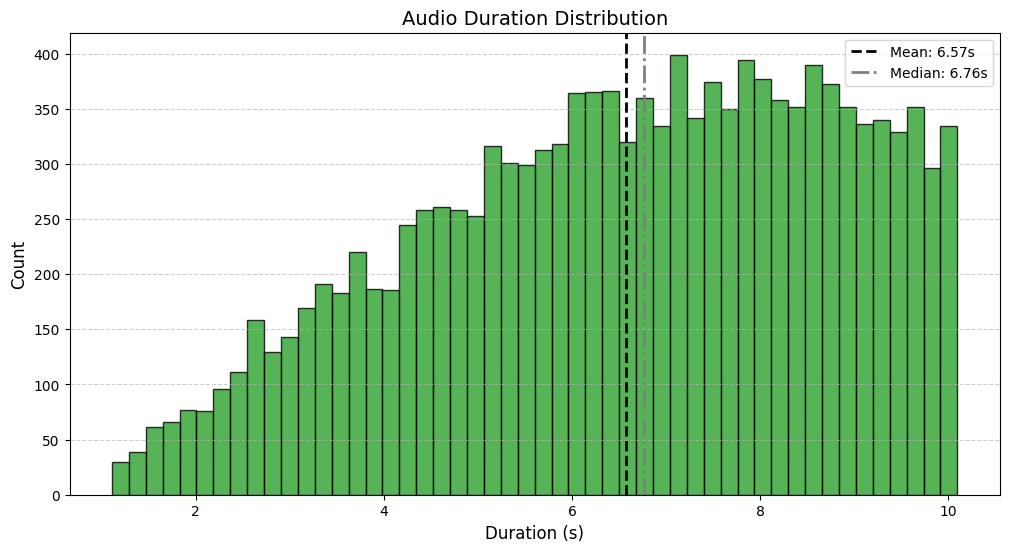

In [55]:
plt.figure(figsize=(12, 6))
plt.hist(durations, bins=50, color='#2ca02c', edgecolor='k', alpha=0.8)
plt.axvline(mean_dur, color='k', linestyle='--', linewidth=2, label=f'Mean: {mean_dur:.2f}s')
plt.axvline(median_dur, color='gray', linestyle='-.', linewidth=2, label=f'Median: {median_dur:.2f}s')
plt.title('Audio Duration Distribution', fontsize=14)
plt.xlabel('Duration (s)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
hist_path = os.path.join(STATS_DIR, 'duration_hist.png')
plt.savefig(hist_path, dpi=300, bbox_inches='tight')
plt.show()

### 7.2. Spectrogram Length vs. Token Length Scatter

In [56]:
spec_lens, token_lens = [], []
for i in random.sample(range(total), 1000):
    wav, _, _, norm = dataset[i]
    spec_lens.append(logmel(wav).shape[1])
    token_lens.append(len(tokenizer.encode(normalize_text(norm))))

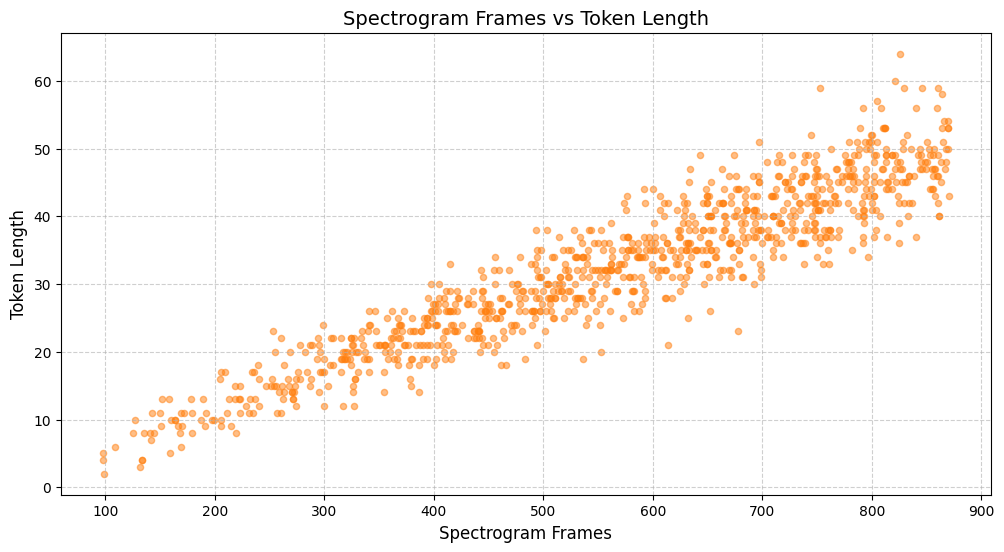

In [57]:
plt.figure(figsize=(12, 6))
plt.scatter(spec_lens, token_lens, alpha=0.5, s=20, color='#ff7f0e')
plt.title('Spectrogram Frames vs Token Length', fontsize=14)
plt.xlabel('Spectrogram Frames', fontsize=12)
plt.ylabel('Token Length', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
scatter_path = os.path.join(STATS_DIR, 'spec_token_scatter.png')
plt.savefig(scatter_path, dpi=300, bbox_inches='tight')
plt.show()

There is an approximately **linear relationship** between spectrogram frame count and token length.  

## 7.3. Example: Waveform + Spectrogram + Tokens

- **Waveform:** Raw amplitude vs time.  
- **Spectrogram:** Log-Mel view; darker regions indicate higher energy.  
- **Tokens:** First 20 subword pieces.  


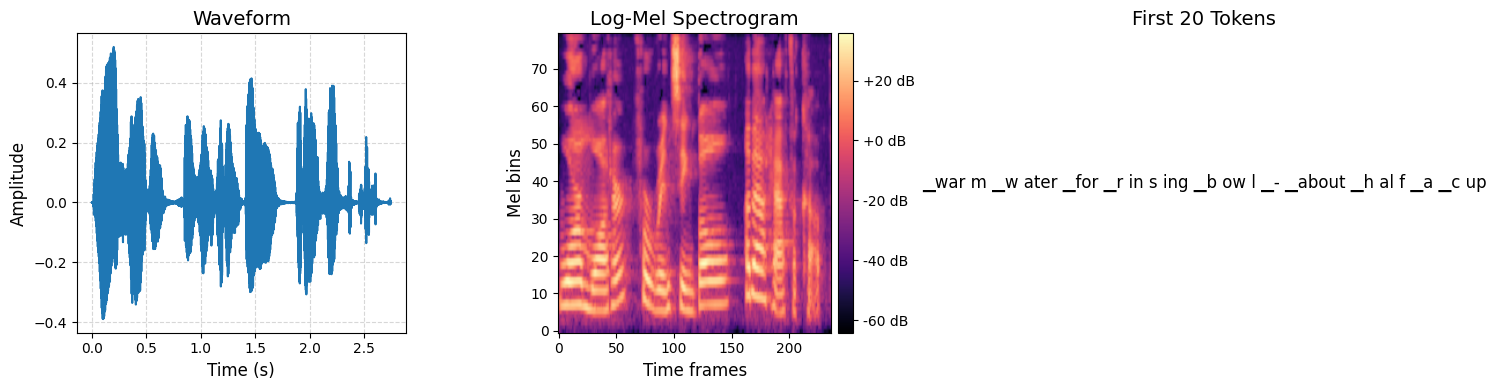

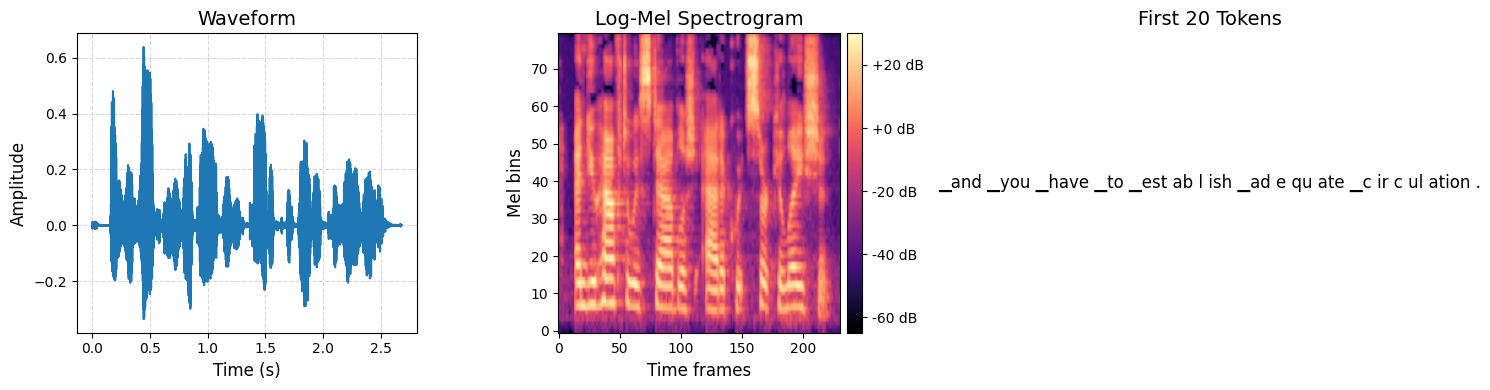

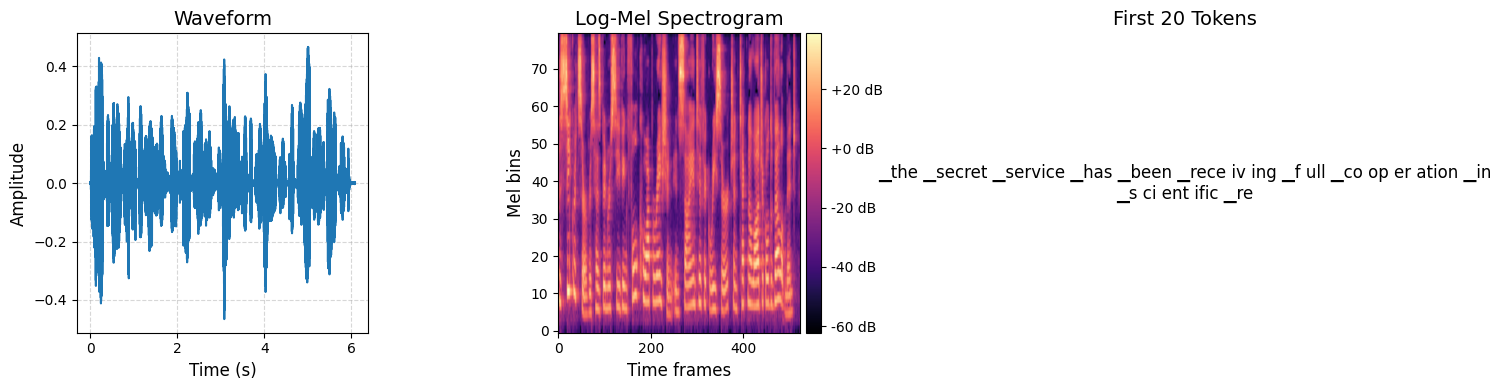

In [60]:
examples_dir = os.path.join(STATS_DIR, "examples")
os.makedirs(examples_dir, exist_ok=True)

for idx in random.sample(range(total), 3):
    wav, sr, _, norm = dataset[idx]
    spec = logmel(wav)
    tokens = tokenizer.encode(normalize_text(norm))

    times = np.arange(wav.shape[1]) / sr
    fig, axes = plt.subplots(1, 3, figsize=(15,4))

    # Waveform
    axes[0].plot(times, wav.squeeze().numpy(), color='#1f77b4')
    axes[0].set_title("Waveform", fontsize=14)
    axes[0].set_xlabel("Time (s)", fontsize=12)
    axes[0].set_ylabel("Amplitude", fontsize=12)
    axes[0].grid(True, linestyle='--', alpha=0.5)

    # Spectrogram
    im = axes[1].imshow(spec.numpy(), origin='lower', aspect='auto', cmap='magma')
    axes[1].set_title("Log-Mel Spectrogram", fontsize=14)
    axes[1].set_xlabel("Time frames", fontsize=12)
    axes[1].set_ylabel("Mel bins", fontsize=12)
    fig.colorbar(im, ax=axes[1], format='%+2.0f dB', pad=0.02)

    # Tokens
    pieces = tokenizer.id_to_piece(tokens[:20])
    axes[2].text(0.5, 0.5, " ".join(pieces), ha='center', va='center', fontsize=12, wrap=True)
    axes[2].set_title("First 20 Tokens", fontsize=14)
    axes[2].axis('off')

    plt.tight_layout()
    example_png = os.path.join(examples_dir, f"example_{idx}.png")
    fig.savefig(example_png, dpi=300, bbox_inches='tight')
    plt.show(); plt.close()